**Introduction**


**Objectifs :** 


*   Mettre en équation la trajectoire de l’outil d’un bras articulé à 2 ddl 
*   Résoudre un problème inverse 
*   Utiliser scipy.optimize pour résoudre un système d’équations non linéaires
*   Programmer et comparer différentes méthodes pour résoudre le système d’équations non linéaires par minimisation du résidu du système

In [1]:
import numpy as np
from scipy import optimize 
import matplotlib.pyplot as plt
from Functions import *
from Gradient import  *
from Newton import *
from Graphics import *
import time



C:\Users\khale\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


On considère le bras articulé à 2 degrés de liberté se comportant de deux segments L1 et L2. La positions de l'organe terminale P(x,y) est pilotée par les angles des articulations $theta1$ et $theta2$.
Notre objectif dans est de résoudre un probleme "inverse" nous permettant de trouver les coordonees articulaires $theta1$ et $theta2$ du robot qui permettent de générer une trajectoire $P[x(t),y(t)]$ donnée. 


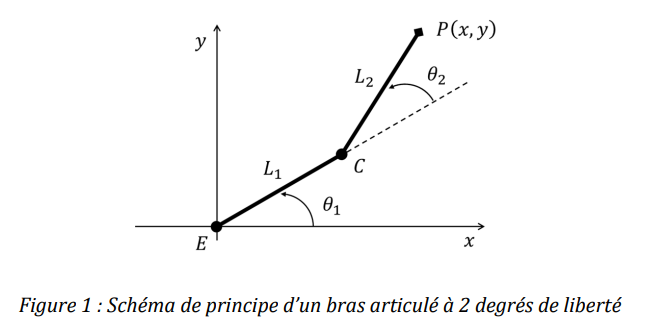

**Equation du modele geometrique directe :**

On definit $X$ le vecteur de positions de l'organe terminal P $X= F(\theta) $ 

$
F(\theta) = 
\begin{pmatrix}
L1 cos	\theta1 + L2 cos(	\theta1 + 	\theta2) \\
L1 sin	\theta1 + L2 sin(	\theta1 + 	\theta2)
\end{pmatrix}$

**Equation du résidu :**

On definit le résidu comme suit : $R(\theta)= F(\theta)-X$

$
R(\theta) = 
\begin{pmatrix}
L1 cos	\theta1 + L2 cos(	\theta1 + 	\theta2) - x\\
L1 sin	\theta1 + L2 sin(	\theta1 + 	\theta2) - y
\end{pmatrix}$

La fonction **Interp** permet de definir une trajectoire à suivre par le robot.Elle peut soit etre cubic sois etre linéaire.

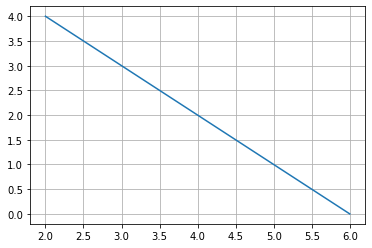

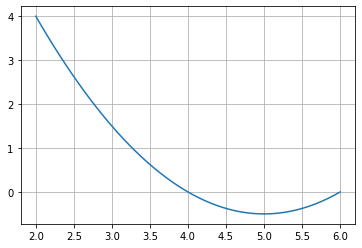

In [2]:
#Interpolation
Xf=[2,4]
Xi=[6,0]
N=50
x,y=Interp(Xi,Xf,N)
plt.figure()
plt.plot(x,y)
plt.grid()
# Pouur une trajectoire cubic
Xi = [2,4]
Xf = [6,0]
Xm = [3,1.5]
N=50
x,y=Interp(Xi,Xf,N,traj="Cube",Xm=Xm)
plt.figure()
plt.plot(x,y)
plt.grid()

In [3]:
# Definition des longueurs des deux segments L1 et L2 du robot
L1 = 3
L2 = 3
# Vecteur de parametres  
Params = [L1,L2,None] # La troisieme valeur de Params est le vecteur de la position desirée X

# Gradient a pas fixe

La méthode du gradient est une méthode d’analyse numérique permettant de trouver un extremum (qui peut être local) d’une fonction à plusieurs variables sans contraintes. 
Dans notre projet on sera amené a utiliser la methodes du gradient pour trouver les angles minimisant la distance de l'organe terminale d'un robot et d'un point defini dans l'espace cartésien (fonction residu).
Aprés avoir matthematiquement modeliser le robot, le probleme posé est de minimiser la norm au carré de la fonction residu precedemment defini : $R_{norm}(\theta) = \lVert R(\theta)\rVert ^ 2 $ definir sur $ R^2 $ avec $\theta = [\theta_1 , \theta_2]$ les positions articulaire du robot.
La fonction $R_{norm}(\theta)$ étant différentiable à l’ordre 1, la methode du gradient permet de generer une suite de points \theta_n tel que :   
$$  \forall n R_{norm}(\theta_{n+1}) <R_{norm}(\theta_n)) $$ 

Pour minimiser $R_{norm}$ il suffit de chercher un nouveau point en se deplacant d'une certaine quantité dans la direction de opposé du gradient de $R_{norm} (\vec\nabla R_{norm}$) . 

Le schema generale de l'algorithme du gradient a pas fixe est decrit pas l'equation suivante : 
$$  X_{n+1} = X_n - \alpha \nabla R_{norm}(X_n) \quad avec \quad R_{norm}(\theta_{n+1} <R_{norm}(\theta_n)) $$
avec  : 

<table border="0">  <tr>    <tr>     <td>$$
\nabla ||R(\theta)||^{2}=
\begin{pmatrix}
\frac{\partial ||R(\theta)||^{2}}{\partial \theta_{1}}\\
\frac{\partial ||R(\theta)||^{2}}{\partial \theta_{2}}
\end{pmatrix}
$$</td>     <td>$$
 =\begin{pmatrix}
2x(L1sin(\theta_{1})+L2sin(\theta_{1}+\theta_{2}))-2y(L1cos(\theta_{1})+L2cos(\theta_{1}+\theta_{2}))\\
-2L1L2sin(\theta_{2})+2xL2sin(\theta_{1}+\theta_{2})-2yL2.cos(\theta_{1}+\theta_{2})
\end{pmatrix}
$$</td>  </tr> </table>
$\alpha$ est constant au cours des itérations. Le pas de déplacement étant proportionnel au module du gradient, il diminue automatiquement au voisinage du minimum et on peut espérer converger vers la solution, à condition de choisir la bonne valeur de 𝛼.
Pour un 𝛼 trés grand l'algorithm peut osciller autour de la solution sans jamais converger, et un 𝛼 trés petit nous assurera de converger vers la solution mais la methode deviens vite trés couteuse (Nombre d'iteration trés elevés).

On definit une position desiré dans l'espace cartesien $\vec X = [2,1] $. Pour avoir une vue destaillé de comment la fonction $R_{norm}$ varies avec \theta on trace les isovaleurs de la fonction $R_{norm}$  pour une position  $\vec X = [2,1] $ comme suit : 

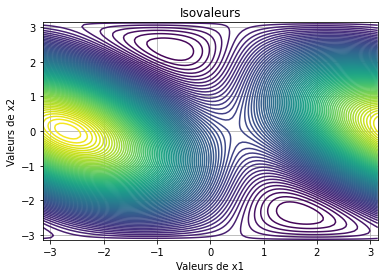

In [10]:
# Definition du point desiré 
X = np.array([2,1])
# Nombre des isovaleurs dans le trancé de Rnorm
nIso = 100 ; 
nx,ny = 100 , 100 
Params[2]= X
# Tracé des Isovaleurs de Rnorm
isoValeurs (Params,nx,ny, nIso)

On constate que pour la position de l'organe terminale du robot choisis, deux configurations articulaires sont possible pour atteindre ce point.Ce qui se traduit par le fait qu'il existe deux configurations articulaire qui minimisent le modules du residu au carré ( $R_{norm}$).
On implemente l'algorithme du gradient a pas optimal avec une configuration initiale \theta = $[\pi/4 ,\pi/4]$


 Iterations : 1 	 alpha = 0.05 	 dX = 0.8129471800465795
 Iterations : 2 	 alpha = 0.05 	 dX = 0.4515481953307078
 Iterations : 3 	 alpha = 0.05 	 dX = 0.4295175833058964
 Iterations : 4 	 alpha = 0.05 	 dX = 0.37867138951615015
 Iterations : 5 	 alpha = 0.05 	 dX = 0.2575421714287201
 Iterations : 6 	 alpha = 0.05 	 dX = 0.14331299262215608
 Iterations : 7 	 alpha = 0.05 	 dX = 0.07749997387254273
 Iterations : 8 	 alpha = 0.05 	 dX = 0.04418164346435653
 Iterations : 9 	 alpha = 0.05 	 dX = 0.026104125008296182
 Iterations : 10 	 alpha = 0.05 	 dX = 0.01572186232539998
 Iterations : 11 	 alpha = 0.05 	 dX = 0.009576701562187711
 Iterations : 12 	 alpha = 0.05 	 dX = 0.005873809401199143
 Iterations : 13 	 alpha = 0.05 	 dX = 0.003617918377131137
 Iterations : 14 	 alpha = 0.05 	 dX = 0.002234229616122271
 Iterations : 15 	 alpha = 0.05 	 dX = 0.0013819573914667042
 Iterations : 16 	 alpha = 0.05 	 dX = 0.0008556439355246434
Minimum trouve apres 16 iterations
les angles optimaux = [-0

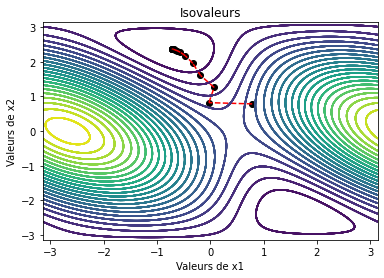

In [11]:
# Configuration articulaire initialle du robot 
ConfigInit =[np.pi/4,np.pi/4]
#Definition de la valeur initialle du pas de l'algorithme du griadient a pas fixe 
aplha_init = 0.05
# Calcule du minimum de la fonction Rnorm
resultat , converge = GradienDecent(ConfigInit,aplha_init,Params,10e-4,100,IsoV=True,Disp=True) 

print(f"les angles optimaux = {resultat} \nLe point (X,Y) = {F(L1,L2,resultat[0],resultat[1])}")


On reprend l'exemple precedent avec une valeur de alpha plus grande  ($\alpha = 0.1$).


In [6]:
# Configuration articulaire initialle du robot 
ConfigInit =[np.pi/4,np.pi/4]
#Definition de la valeur initialle du pas de l'algorithme du griadient a pas fixe 
aplha_init = 0.1
# Calcule du minimum de la fonction Rnorm
resultat , converge = GradienDecent(ConfigInit,aplha_init,Params,10e-4,100,Disp=True) 

print(f"les angles optimaux = {resultat} \nLe point X = {F(L1,L2,resultat[0],resultat[1])}")


 Iterations : 1 	 alpha = 0.1 	 dX = 1.625894360093159
 Iterations : 2 	 alpha = 0.1 	 dX = 2.6938288474597973
 Iterations : 3 	 alpha = 0.1 	 dX = 0.9998110842310913
 Iterations : 4 	 alpha = 0.1 	 dX = 0.6823706457291661
 Iterations : 5 	 alpha = 0.1 	 dX = 0.5639312339639075
 Iterations : 6 	 alpha = 0.1 	 dX = 0.28294325845070917
 Iterations : 7 	 alpha = 0.1 	 dX = 0.2468783936432425
 Iterations : 8 	 alpha = 0.1 	 dX = 0.2396249479859034
 Iterations : 9 	 alpha = 0.1 	 dX = 0.2397133119545521
 Iterations : 10 	 alpha = 0.1 	 dX = 0.24089281789986547
 Iterations : 11 	 alpha = 0.1 	 dX = 0.24205757927123903
 Iterations : 12 	 alpha = 0.1 	 dX = 0.24351230317429196
 Iterations : 13 	 alpha = 0.1 	 dX = 0.24459436468681303
 Iterations : 14 	 alpha = 0.1 	 dX = 0.24588495529226256
 Iterations : 15 	 alpha = 0.1 	 dX = 0.24682244254005392
 Iterations : 16 	 alpha = 0.1 	 dX = 0.2479367145411524
 Iterations : 17 	 alpha = 0.1 	 dX = 0.24874096383640734
 Iterations : 18 	 alpha = 0.1 	 

Avec cette valeurs de alpha on constate que l'algorithme oscille autour de la solution sans y converger et ca meme pour un nombre d'iterations plus elevés.

Pour amelierer l'algortihme du gradient a pas fixe, on ajuste la valeur de alpha en le divisant sur deux si $  R_{norm}(\theta_{n+1}) > R_{norm}(\theta_n)) $ qui permet de garantir la convergence.

In [7]:
# Configuration articulaire initialle du robot 
ConfigInit =[-np.pi/4,-np.pi/4]
#Definition de la valeur initialle du pas de l'algorithme du griadient a pas fixe 
aplha_init = 0.1
# Calcule du minimum de la fonction Rnorm
resultat , converge = GradienDecentAmeliore(ConfigInit,aplha_init,Params,10e-4,100,IsoV,Disp=True)
print(f"les angles optimaux = {resultat} \nLe point X = {F(L1,L2,resultat[0],resultat[1])}")

 Iterations : 1 	 alpha = 0.05 	 dX = 1.625894360093159
 Iterations : 2 	 alpha = 0.1 	 dX = 1.3469144237298987
 Iterations : 3 	 alpha = 0.1 	 dX = 0.9441137369478272
 Iterations : 4 	 alpha = 0.05 	 dX = 0.3012079174441514
 Iterations : 5 	 alpha = 0.1 	 dX = 0.14718983497074895
 Iterations : 6 	 alpha = 0.1 	 dX = 0.029237375260530284
 Iterations : 7 	 alpha = 0.05 	 dX = 0.025205619963255037
 Iterations : 8 	 alpha = 0.1 	 dX = 0.012920661390454079
 Iterations : 9 	 alpha = 0.1 	 dX = 0.0007323899315723433
Minimum trouve apres 9 iterations
les angles optimaux = [-0.72499566  2.37787387] 
Le point X = [1.99953767 1.00050294]


In [ ]:
# Configuration articulaire initialle du robot 
ConfigInit =[np.pi/4,np.pi/4]
#Definition de la valeur initialle du pas de l'algorithme du griadient a pas fixe 
aplha_init = 0.1
# Calcule du minimum de la fonction Rnorm
resultat , converge = GradienDecentAmeliore(ConfigInit,aplha_init,Params,10e-4,100,Disp=True)
print(f"les angles optimaux = {resultat} \nLe point X = {F(L1,L2,resultat[0],resultat[1])}")

Gradient ne converge pas


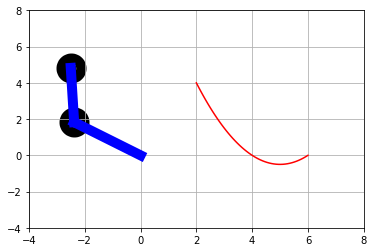

Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas


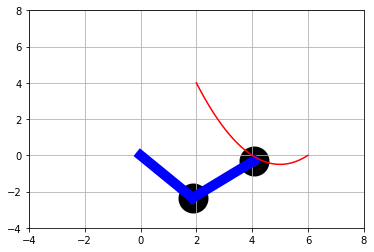

Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas


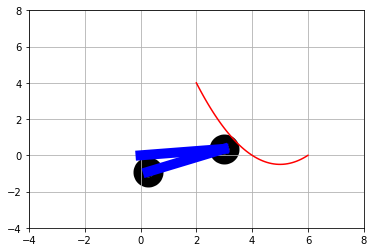

Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas


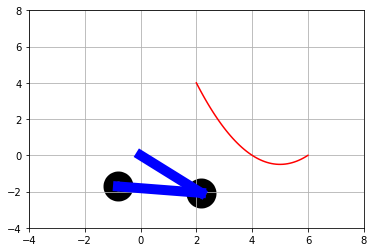

Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas


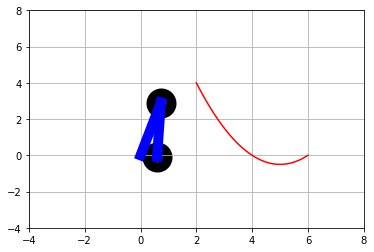

Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas
Gradient ne converge pas


In [8]:
q = [-2,0] 
ptAfficher = 10 
plt.figure()
for i in  range(N): 
    X=[x[i],y[i]]
    Params[2] = X
    rt=optimize.root(R,q,args=Params, jac=False)
    rt,tr = GradienDecent(q,aplha_init,Params,10e-4,100)
    if (i%ptAfficher == 0 ):
        animate(rt,Params)
        plt.plot(x,y,'r', label = 'droite')
        plt.grid()
        plt.show()
    q = rt
    
  
   